In [1]:
from keras.datasets import mnist
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics
from sklearn import manifold
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
import time
from sklearn.neighbors import NearestNeighbors
from keras import regularizers
from keras.layers import Lambda
import tensorflow as tf
#from sklearn.metrics.pairwise import cosine_similarity
import metrics
from keras.models import Sequential, Model

C:\Users\stf4041\Documents\DownloadedSoftware\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load dataset for convolutional input

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
print (x.shape)
x = np.divide(x, 255.) #reduced to 1000 samples to allow the dbscan to run
#print (x)

(70000, 28, 28, 1)


In [3]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
def antirectifier(x):
    #x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    return x

def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    norm = Lambda(lambda y: K.l2_normalize(y, axis=1))
    model = Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))

    model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))

    model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))

    model.add(Flatten())
    model.add(Dense(units=filters[3], name='embedding'))
    model.add(Lambda(antirectifier))
    model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))

    model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))

    model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))

    model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model

In [5]:
class DCEC(object):
    def __init__(self,
                 input_shape,
                 filters=[32, 64, 128, 10],
                 n_clusters=10,
                 alpha=1.0):

        super(DCEC, self).__init__()

        self.n_clusters = n_clusters
        self.input_shape = input_shape
        self.alpha = alpha
        self.pretrained = False
        self.y_pred = []

        self.cae = CAE(input_shape, filters)
        hidden = self.cae.get_layer(name='embedding').output
        self.encoder = Model(inputs=self.cae.input, outputs=hidden)

        # Define DCEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.cae.input,
                           outputs=[clustering_layer, self.cae.output])

    def pretrain(self, x, batch_size=256, epochs=200, optimizer='adam', save_dir='results/temp'):
        print('...Pretraining...')
        self.cae.compile(optimizer=optimizer, loss='mse')
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger(save_dir + '/pretrain_log.csv')

        # begin training
        #t0 = time()
        self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
        #print('Pretraining time: ', time() - t0)
        self.cae.save(save_dir + '/pretrain_cae_model.h5')
        print('Pretrained weights are saved to %s/pretrain_cae_model.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        return self.encoder.predict(x)

    def predict(self, x):
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, loss=['kld', 'mse'], loss_weights=[1, 1], optimizer='adam'):
        self.model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)

    def fit(self, x, y=None, batch_size=256, maxiter=2e4, tol=1e-3,
            update_interval=140, cae_weights=None, save_dir='./results/temp'):
        
        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5
        print('Save interval', save_interval)

        # Step 1: pretrain if necessary
        #t0 = time()
        if not self.pretrained and cae_weights is None:
            print('...pretraining CAE using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x, batch_size, save_dir=save_dir)
            self.pretrained = True
        elif cae_weights is not None:
            self.cae.load_weights(cae_weights)
            print('cae_weights is loaded successfully.')

        # Step 2: initialize cluster centers using k-means
        #t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        
        
        # Step 3: deep clustering
        # logging file
        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/dcec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        #t2 = time()
        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.nmi(y, self.y_pred), 5)
                    ari = np.round(metrics.ari(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2])
                    logwriter.writerow(logdict)
                    print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss)

                # check stop criterion
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            if (index + 1) * batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * batch_size::],
                                                 y=[p[index * batch_size::], x[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * batch_size:(index + 1) * batch_size],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    x[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save DCEC model checkpoints
                print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

            ite += 1



In [6]:
save_dir = 'results/temp'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n_clusters = 10
dcec = DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
dcec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
lambda_2 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
__________

In [7]:
optimizer = 'adam'
gamma = 0.1
dcec.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
#dcec.fit(x, y=y)

In [8]:
dcec.fit(x, y=y)

Update interval 140
Save interval 1367.1875
...pretraining CAE using default hyper-parameters:
   optimizer='adam';   epochs=200
...Pretraining...
Epoch 1/200
70000/70000 [==============================] - 55s 782us/step - loss: 0.0409
Epoch 2/200
70000/70000 [==============================] - 54s 774us/step - loss: 0.0203
Epoch 3/200
70000/70000 [==============================] - 54s 776us/step - loss: 0.0175
Epoch 4/200
70000/70000 [==============================] - 55s 779us/step - loss: 0.0161
Epoch 5/200
70000/70000 [==============================] - 54s 773us/step - loss: 0.0152
Epoch 6/200
70000/70000 [==============================] - 54s 773us/step - loss: 0.0146
Epoch 7/200
70000/70000 [==============================] - 54s 771us/step - loss: 0.0141
Epoch 8/200
70000/70000 [==============================] - 54s 772us/step - loss: 0.0137
Epoch 9/200
70000/70000 [==============================] - 54s 772us/step - loss: 0.0134
Epoch 10/200
70000/70000 [==========================

70000/70000 [==============================] - 54s 773us/step - loss: 0.0090
Epoch 180/200
70000/70000 [==============================] - 54s 773us/step - loss: 0.0090
Epoch 181/200
70000/70000 [==============================] - 54s 773us/step - loss: 0.0090
Epoch 182/200
70000/70000 [==============================] - 54s 777us/step - loss: 0.0090
Epoch 183/200
70000/70000 [==============================] - 54s 772us/step - loss: 0.0090
Epoch 184/200
70000/70000 [==============================] - 54s 773us/step - loss: 0.0090
Epoch 185/200
70000/70000 [==============================] - 54s 774us/step - loss: 0.0090
Epoch 186/200
70000/70000 [==============================] - 54s 772us/step - loss: 0.0090
Epoch 187/200
70000/70000 [==============================] - 54s 771us/step - loss: 0.0090
Epoch 188/200
70000/70000 [==============================] - 54s 772us/step - loss: 0.0090
Epoch 189/200
70000/70000 [==============================] - 54s 770us/step - loss: 0.0090
Epoch 190/200

C:\Users\stf4041\Documents\DownloadedSoftware\envs\py36\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0 : Acc 0.9445 , nmi 0.87651 , ari 0.88077 ; loss= [0 0 0]
saving model to: ./results/temp/dcec_model_0.h5
Iter 140 : Acc 0.95761 , nmi 0.90204 , ari 0.90871 ; loss= [0.01525 0.03935 0.01131]
Iter 280 : Acc 0.96591 , nmi 0.91762 , ari 0.92618 ; loss= [0.02467 0.08691 0.01598]
Iter 420 : Acc 0.97044 , nmi 0.92638 , ari 0.93578 ; loss= [0.03005 0.12107 0.01794]
Iter 560 : Acc 0.9725 , nmi 0.93017 , ari 0.94016 ; loss= [0.02862 0.11328 0.01729]
Iter 700 : Acc 0.9749 , nmi 0.93527 , ari 0.94533 ; loss= [0.02748 0.10276 0.01721]
Iter 840 : Acc 0.97577 , nmi 0.93701 , ari 0.94719 ; loss= [0.025   0.09534 0.01547]
Iter 980 : Acc 0.97663 , nmi 0.93899 , ari 0.94904 ; loss= [0.02485 0.09161 0.01569]
Iter 1120 : Acc 0.97726 , nmi 0.94023 , ari 0.9504 ; loss= [0.02459 0.09079 0.01551]
Iter 1260 : Acc 0.97754 , nmi 0.94091 , ari 0.951 ; loss= [0.02444 0.0889  0.01555]
Iter 1400 : Acc 0.97789 , nmi 0.9417 , ari 0.95171 ; loss= [0.02421 0.08857 0.01536]
Iter 1540 : Acc 0.97813 , nmi 0.94226 , a

In [9]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

met_nmi = normalized_mutual_info_score
met_ari = adjusted_rand_score


def accu(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size 

In [10]:
y_pred = dcec.y_pred

In [11]:
print('acc:', accu(y, y_pred))

acc: 0.9810857142857143


In [12]:
def visualizeData(Z, labels, num_clusters, title):
    '''TSNE visualization of the points in latent space Z
    :param Z: Numpy array containing points in latent space in which clustering was performed
    :param labels: True labels - used for coloring points
    :param num_clusters: Total number of clusters
    :param title: filename where the plot should be saved
    :return: None - (side effect) saves clustering visualization plot in specified location'''
    labels = labels.astype(int)
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    #Z_tsne = np.squeeze(tsne.fit_transform(Z.reshape(-1,1))) #Mleen added squeeze
    Z_tsne = tsne.fit_transform(Z)
    print (Z_tsne)
    #print (Z_tsne[:, 1])
    fig = plt.figure()
    plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], s=2, c=labels, cmap=plt.cm.get_cmap("jet", num_clusters))
    plt.colorbar(ticks=range(num_clusters))
    fig.savefig(title, dpi=fig.dpi)

In [13]:
encoded = dcec.encoder.predict(x)

[[-30.372486   -0.7733181]
 [-15.640977   28.228704 ]
 [ 53.633972    1.2883842]
 ...
 [ 48.292187   11.564295 ]
 [-53.8221      1.8966876]
 [ -0.6341051  44.0418   ]]


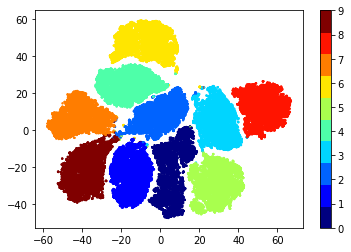

In [14]:
visualizeData(encoded, y_pred, n_clusters, "autoencoder.png")